# TensorFlow Tutorial #13
# Visual Analysis

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

In some of the previous tutorials on Convolutional Neural Networks, we showed the convolutional filter weights, see e.g. Tutorial #02 and #06. But it was impossible to determine what the convolutional filters might be recognizing in the input image from merely looking at the filter-weights.

In this tutorial we will present a basic method for visually analysing the inner-workings of a neural network. The idea is to generate an image that maximizes individual features inside the neural network. The image is initialized with a little random noise and then gradually changed using the gradient of the given feature with regard to the input image.

This method for visual analysis of a neural network is also known as *feature maximization* or *activation maximization*.

This builds on the previous tutorials. You should be familiar with neural networks in general (e.g. Tutorial #01 and #02), and knowledge of the Inception model is also helpful (Tutorial #07).

## Flowchart

We will use the Inception model from Tutorial #07. We want to find an input image that maximizes a given feature inside the neural network. The input image is initialized with a little noise and is then updated using the gradient of the given feature. After performing a number of these optimization iterations we get an image that this particular feature 'likes to see'.

Because the Inception model is constructed from many basic mathematical operations that have been combined, TensorFlow allows us to easily find the gradient using the chain-rule of differentiation.

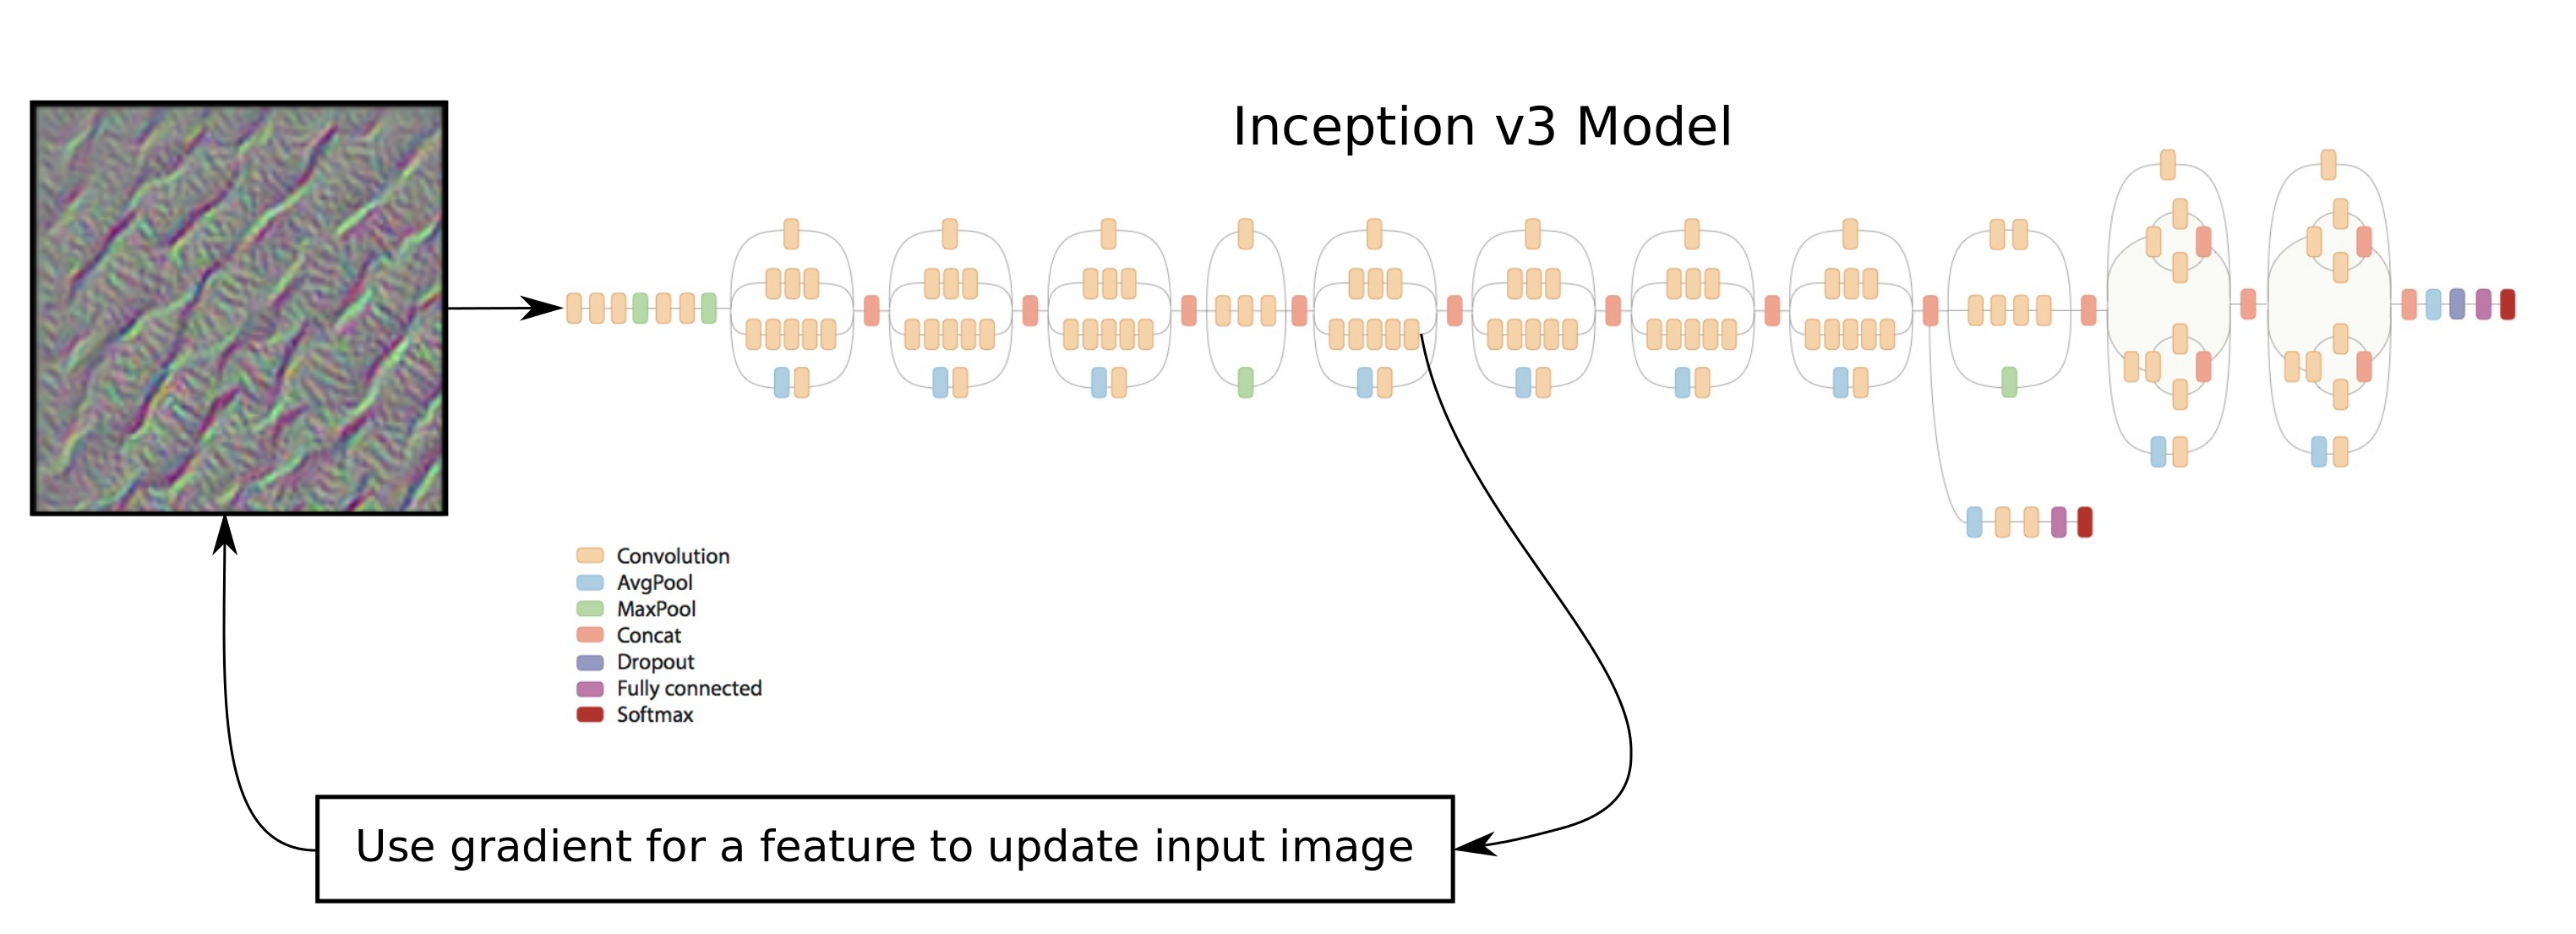

In [44]:
from IPython.display import Image, display
Image('images/13_visual_analysis_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Functions and classes for loading and using the Inception model.
import inception

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'0.11.0rc0'

## Inception Model

### Download the Inception model from the internet

The Inception model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [4]:
# inception.data_dir = 'inception/'

Download the data for the Inception model if it doesn't already exist in the directory. It is 85 MB.

In [5]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


### Names of convolutional layers

This function returns a list of names for the convolutional layers in the Inception model.

In [6]:
def get_conv_layer_names():
    # Load the Inception model.
    model = inception.Inception()
    
    # Create a list of names for the operations in the graph
    # for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in model.graph.get_operations() if op.type=='Conv2D']

    # Close the TensorFlow session inside the model-object.
    model.close()

    return names

In [7]:
conv_names = get_conv_layer_names()

There are a total of 94 convolutional layers in this Inception model.

In [8]:
len(conv_names)

94

Show the names of the first 5 convolutional layers.

In [9]:
conv_names[:5]

['conv/Conv2D',
 'conv_1/Conv2D',
 'conv_2/Conv2D',
 'conv_3/Conv2D',
 'conv_4/Conv2D']

Show the names of the last 5 convolutional layers.

In [10]:
conv_names[-5:]

['mixed_10/tower_1/conv/Conv2D',
 'mixed_10/tower_1/conv_1/Conv2D',
 'mixed_10/tower_1/mixed/conv/Conv2D',
 'mixed_10/tower_1/mixed/conv_1/Conv2D',
 'mixed_10/tower_2/conv/Conv2D']

## Helper-function for finding the input image

This function finds the input image that maximizes a given feature in the network. It essentially just performs optimization with gradient ascent. The image is initialized with small random values and is then iteratively updated using the gradient for the given feature with regard to the image.

In [11]:
def optimize_image(conv_id=None, feature=0,
                   num_iterations=30, show_progress=True):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last fully-connected layer
             before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    """

    # Load the Inception model. This is done for each call of
    # this function because we will add a lot to the graph
    # which will cause the graph to grow and eventually the
    # computer will run out of memory.
    model = inception.Inception()

    # Reference to the tensor that takes the raw input image.
    resized_image = model.resized_image

    # Reference to the tensor for the predicted classes.
    # This is the output of the final layer's softmax classifier.
    y_pred = model.y_pred

    # Create the loss-function that must be maximized.
    if conv_id is None:
        # If we want to maximize a feature on the last layer,
        # then we use the fully-connected layer prior to the
        # softmax-classifier. The feature no. is the class-number
        # and must be an integer between 1 and 1000.
        # The loss-function is just the value of that feature.
        loss = model.y_logits[0, feature]
    else:
        # If instead we want to maximize a feature of a
        # convolutional layer inside the neural network.

        # Get the name of the convolutional operator.
        conv_name = conv_names[conv_id]
        
        # Get a reference to the tensor that is output by the
        # operator. Note that ":0" is added to the name for this.
        tensor = model.graph.get_tensor_by_name(conv_name + ":0")

        # Set the Inception model's graph as the default
        # so we can add an operator to it.
        with model.graph.as_default():
            # The loss-function is the average of all the
            # tensor-values for the given feature. This
            # ensures that we generate the whole input image.
            # You can try and modify this so it only uses
            # a part of the tensor.
            loss = tf.reduce_mean(tensor[:,:,:,feature])
    
    # Get the gradient for the loss-function with regard to
    # the resized input image. This creates a mathematical
    # function for calculating the gradient.
    gradient = tf.gradients(loss, resized_image)

    # Create a TensorFlow session so we can run the graph.
    session = tf.Session(graph=model.graph)

    # Generate a random image of the same size as the raw input.
    # Each pixel is a small random value between 128 and 129,
    # which is about the middle of the colour-range.
    image_shape = resized_image.get_shape()
    image = np.random.uniform(size=image_shape) + 128.0

    # Perform a number of optimization iterations to find
    # the image that maximizes the loss-function.
    for i in range(num_iterations):
        # Create a feed-dict. This feeds the image to the
        # tensor in the graph that holds the resized image, because
        # this is the final stage for inputting raw image data.
        feed_dict = {model.tensor_name_resized_image: image}

        # Calculate the predicted class-scores,
        # as well as the gradient and the loss-value.
        pred, grad, loss_value = session.run([y_pred, gradient, loss],
                                             feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # input image in order to maximize the given feature.

        # Calculate the step-size for updating the image.
        # This step-size was found to give fast convergence.
        # The addition of 1e-8 is to protect from div-by-zero.
        step_size = 1.0 / (grad.std() + 1e-8)

        # Update the image by adding the scaled gradient
        # This is called gradient ascent.
        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)

        if show_progress:
            print("Iteration:", i)

            # Convert the predicted class-scores to a one-dim array.
            pred = np.squeeze(pred)

            # The predicted class for the Inception model.
            pred_cls = np.argmax(pred)

            # Name of the predicted class.
            cls_name = model.name_lookup.cls_to_name(pred_cls,
                                               only_first_name=True)

            # The score (probability) for the predicted class.
            cls_score = pred[pred_cls]

            # Print the predicted score etc.
            msg = "Predicted class-name: {0} (#{1}), score: {2:>7.2%}"
            print(msg.format(cls_name, pred_cls, cls_score))

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Print the loss-value.
            print("Loss:", loss_value)

            # Newline.
            print()

    # Close the TensorFlow session inside the model-object.
    model.close()

    return image.squeeze()

### Helper-function for plotting image and noise

This function normalizes an image so its pixel-values are between 0.0 and 1.0.

In [12]:
def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

This function plots a single image.

In [13]:
def plot_image(image):
    # Normalize the image so pixels are between 0.0 and 1.0
    img_norm = normalize_image(image)
    
    # Plot the image.
    plt.imshow(img_norm, interpolation='nearest')
    plt.show()

This function plots 6 images in a grid.

In [14]:
def plot_images(images, show_size=100):
    """
    The show_size is the number of pixels to show for each image.
    The max value is 299.
    """

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 3)

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # For each entry in the grid.
    for i, ax in enumerate(axes.flat):
        # Get the i'th image and only use the desired pixels.
        img = images[i, 0:show_size, 0:show_size, :]
        
        # Normalize the image so its pixels are between 0.0 and 1.0
        img_norm = normalize_image(img)
        
        # Plot the image.
        ax.imshow(img_norm, interpolation=interpolation)

        # Remove ticks.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()    

### Helper-function for optimizing and plotting images

This function optimizes multiple images and plots them.

In [15]:
def optimize_images(conv_id=None, num_iterations=30, show_size=100):
    """
    Find 6 images that maximize the 6 first features in the layer
    given by the conv_id.
    
    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last layer before the softmax output.
    num_iterations: Number of optimization iterations to perform.
    show_size: Number of pixels to show for each image. Max 299.
    """

    # Which layer are we using?
    if conv_id is None:
        print("Final fully-connected layer before softmax.")
    else:
        print("Layer:", conv_names[conv_id])

    # Initialize the array of images.
    images = []

    # For each feature do the following. Note that the
    # last fully-connected layer only supports numbers
    # between 1 and 1000, while the convolutional layers
    # support numbers between 0 and some other number.
    # So we just use the numbers between 1 and 7.
    for feature in range(1,7):
        print("Optimizing image for feature no.", feature)
        
        # Find the image that maximizes the given feature
        # for the network layer identified by conv_id (or None).
        image = optimize_image(conv_id=conv_id, feature=feature,
                               show_progress=False,
                               num_iterations=num_iterations)

        # Squeeze the dim of the array.
        image = image.squeeze()

        # Append to the list of images.
        images.append(image)

    # Convert to numpy-array so we can index all dimensions easily.
    images = np.array(images)

    # Plot the images.
    plot_images(images=images, show_size=show_size)

## Results

### Optimize a single image for an early convolutional layer

As an example, find an input image that maximizes feature no. 2 of the convolutional layer with the name `conv_names[conv_id]` where `conv_id=5`.

In [16]:
image = optimize_image(conv_id=5, feature=2,
                       num_iterations=30, show_progress=True)

Iteration: 0
Predicted class-name: dishwasher (#667), score:   5.59%
Gradient min: -0.000089, max:  0.000125, stepsize:  76178.66
Loss: 4.83987

Iteration: 1
Predicted class-name: kite (#397), score:  11.12%
Gradient min: -0.000103, max:  0.000109, stepsize:  72136.10
Loss: 5.59879

Iteration: 2
Predicted class-name: wall clock (#524), score:   5.48%
Gradient min: -0.000111, max:  0.000145, stepsize:  80405.14
Loss: 6.91441

Iteration: 3
Predicted class-name: ballpoint (#907), score:   5.42%
Gradient min: -0.000123, max:  0.000120, stepsize:  86825.41
Loss: 7.90217

Iteration: 4
Predicted class-name: syringe (#531), score:  13.64%
Gradient min: -0.000113, max:  0.000102, stepsize:  95255.84
Loss: 8.85303

Iteration: 5
Predicted class-name: syringe (#531), score:  22.57%
Gradient min: -0.000100, max:  0.000093, stepsize: 103656.49
Loss: 9.69852

Iteration: 6
Predicted class-name: syringe (#531), score:  25.47%
Gradient min: -0.000093, max:  0.000112, stepsize: 112196.24
Loss: 10.4557

I

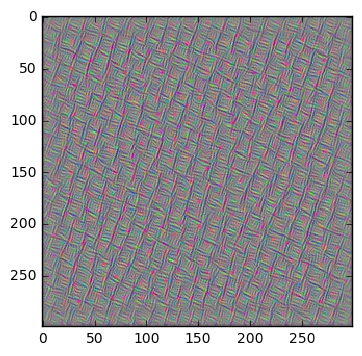

In [17]:
plot_image(image)

### Optimize multiple images for convolutional layers

In the following we optimize and plot multiple images for convolutional layers inside the Inception model. These images show what the layers 'like to see'. Notice how the patterns become increasingly complex for deeper layers.

Layer: conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


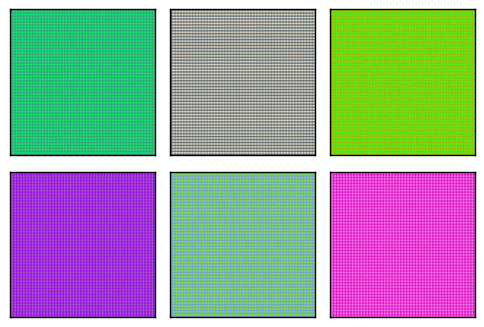

In [18]:
optimize_images(conv_id=0, num_iterations=10)

Layer: conv_3/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


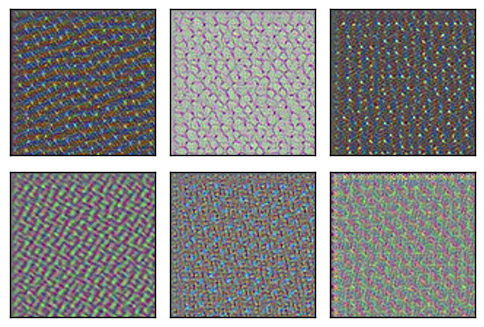

In [19]:
optimize_images(conv_id=3, num_iterations=30)

Layer: conv_4/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


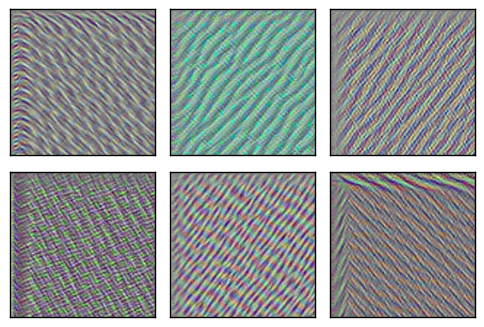

In [20]:
optimize_images(conv_id=4, num_iterations=30)

Layer: mixed/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


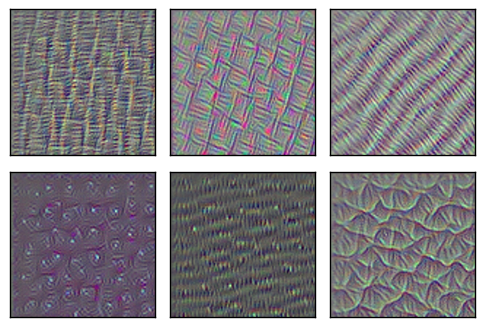

In [21]:
optimize_images(conv_id=5, num_iterations=30)

Layer: mixed/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


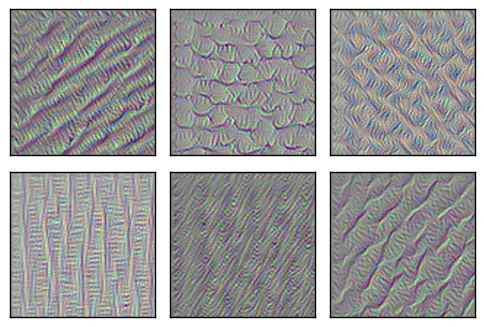

In [22]:
optimize_images(conv_id=6, num_iterations=30)

Layer: mixed/tower/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


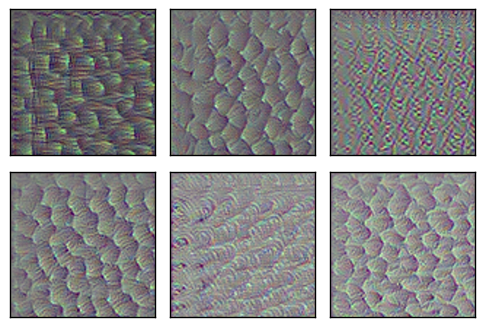

In [23]:
optimize_images(conv_id=7, num_iterations=30)

Layer: mixed/tower_1/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


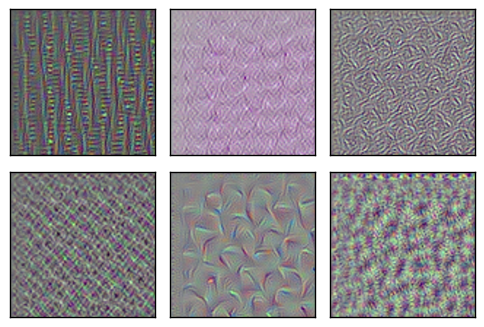

In [24]:
optimize_images(conv_id=8, num_iterations=30)

Layer: mixed/tower_1/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


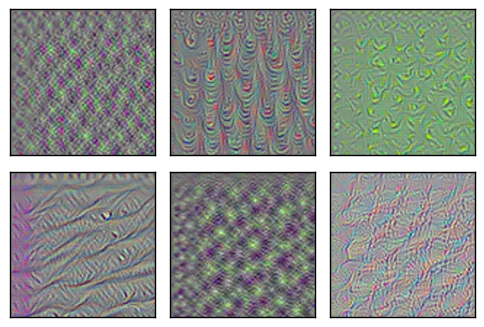

In [25]:
optimize_images(conv_id=9, num_iterations=30)

Layer: mixed/tower_1/conv_2/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


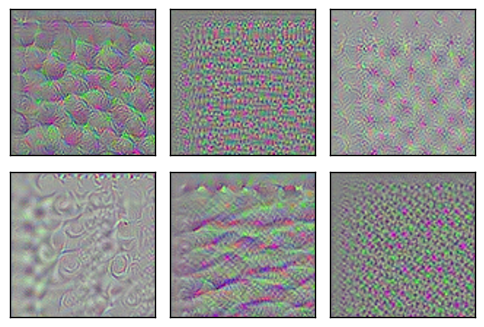

In [26]:
optimize_images(conv_id=10, num_iterations=30)

Layer: mixed_2/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


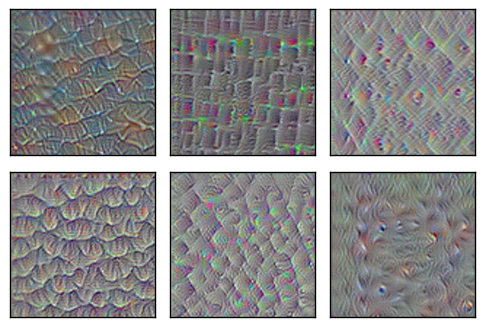

In [27]:
optimize_images(conv_id=20, num_iterations=30)

Layer: mixed_4/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


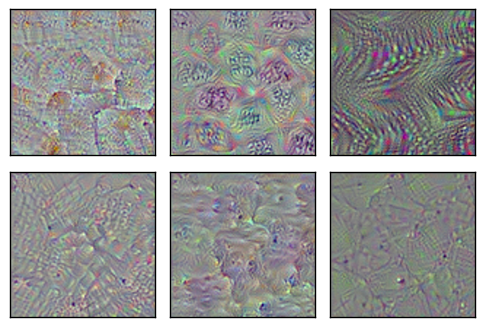

In [28]:
optimize_images(conv_id=30, num_iterations=30)

Layer: mixed_5/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


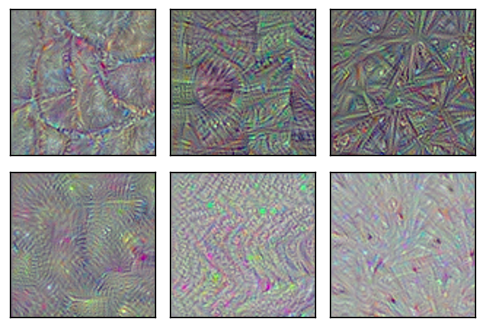

In [29]:
optimize_images(conv_id=40, num_iterations=30)

Layer: mixed_6/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


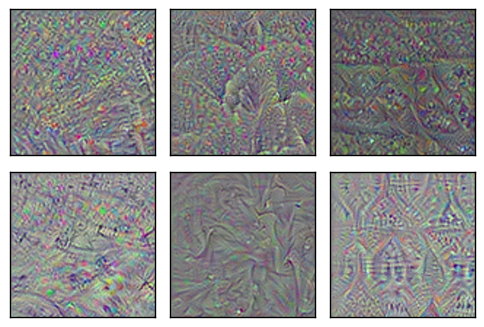

In [30]:
optimize_images(conv_id=50, num_iterations=30)

Layer: mixed_7/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


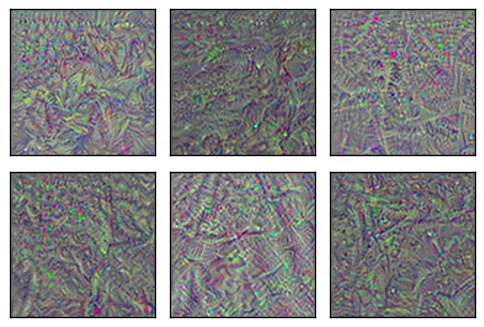

In [31]:
optimize_images(conv_id=60, num_iterations=30)

Layer: mixed_8/tower/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


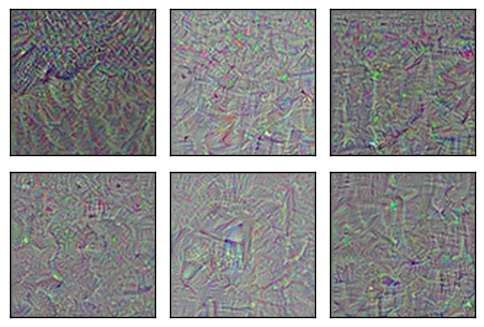

In [32]:
optimize_images(conv_id=70, num_iterations=30)

Layer: mixed_9/tower_1/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


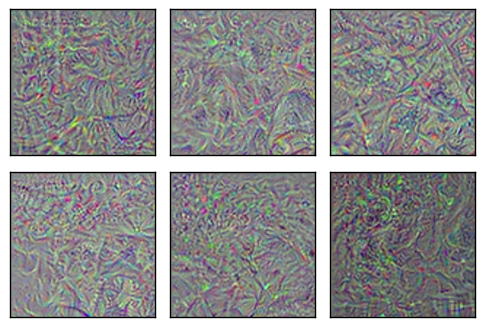

In [33]:
optimize_images(conv_id=80, num_iterations=30)

Layer: mixed_10/tower_1/conv_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


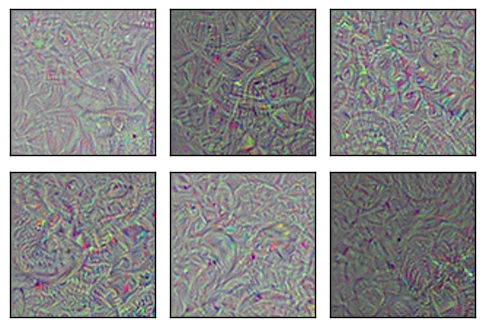

In [34]:
optimize_images(conv_id=90, num_iterations=30)

Layer: mixed_10/tower_2/conv/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


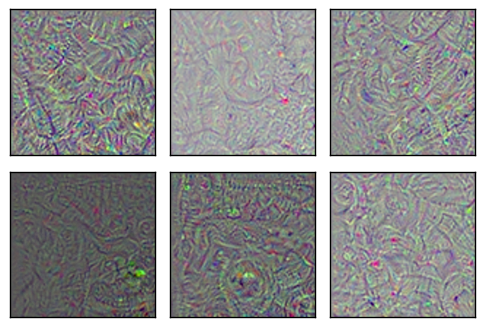

In [35]:
optimize_images(conv_id=93, num_iterations=30)

### Final fully-connected layer before Softmax

Now we optimize and plot images for the final layer in the Inception model. This is the fully-connected layer right before the softmax-classifier. The features in this layer correspond to output classes.

We might have hoped to see recognizable patterns in these images, e.g. monkeys and birds corresponding to the output classes, but the images just show complex, abstract patterns.

Final fully-connected layer before softmax.
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


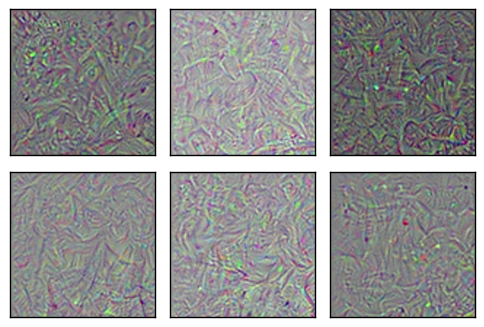

In [36]:
optimize_images(conv_id=None, num_iterations=30)

The above images only show 100x100 pixels but the images are actually 299x299 pixels. It is possible that there might be recognizable patterns if we optimize for more iterations and plot the full image. So let us optimize the first image again and plot it in full resolution.

The Inception model classifies the resulting image as a 'kit fox' with about 100% certainty, but to the human eye the image just shows abstract patterns.

If you want to try this for another feature number, note that it must be between 1 and 1000 because it must correspond to a valid class-number for the final output-layer.

In [37]:
image = optimize_image(conv_id=None, feature=1,
                       num_iterations=100, show_progress=True)

Iteration: 0
Predicted class-name: dishwasher (#667), score:   4.98%
Gradient min: -0.006252, max:  0.004451, stepsize:   3734.48
Loss: -0.837608

Iteration: 1
Predicted class-name: ballpoint (#907), score:   8.52%
Gradient min: -0.007303, max:  0.006427, stepsize:   2152.89
Loss: -0.416723

Iteration: 2
Predicted class-name: spider web (#600), score:  90.44%
Gradient min: -0.007480, max:  0.012272, stepsize:   1343.66
Loss: 2.77814

Iteration: 3
Predicted class-name: pot (#838), score:   3.01%
Gradient min: -0.009853, max:  0.007638, stepsize:   1526.98
Loss: 3.27751

Iteration: 4
Predicted class-name: American egret (#426), score:  11.55%
Gradient min: -0.008507, max:  0.006308, stepsize:   1787.96
Loss: 5.95497

Iteration: 5
Predicted class-name: spider web (#600), score:  21.98%
Gradient min: -0.010415, max:  0.009410, stepsize:   1722.27
Loss: 5.07394

Iteration: 6
Predicted class-name: kit fox (#1), score:  29.21%
Gradient min: -0.009298, max:  0.007885, stepsize:   2471.91
Loss:

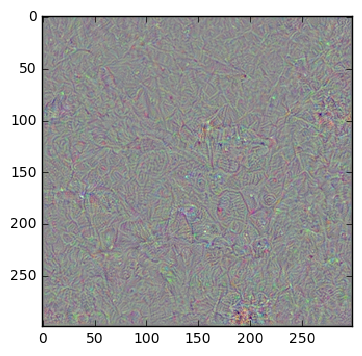

In [38]:
plot_image(image=image)

## Close TensorFlow Session

The TensorFlow session was already closed in the functions above that used the Inception model. This was done to save memory so the computer would not crash when adding many gradient-functions to the computational graph.

## Conclusion

This tutorial showed how to optimize input images that maximize features inside a neural network. This allows us to visually analyze what the neural network 'likes to see', because the given feature (or neuron) inside the neural network reacts most strongly to that particular image.

For the lower layers in the neural network, the images had simple patterns, e.g. different types of wavy lines. The image patterns become increasingly complex for deeper layers of the neural network. We might have expected or hoped that the image patterns would be recognizable for deeper layers, e.g. showing monkeys, foxes, cars, etc. But instead the image patterns become increasingly complex and abstract for the deeper layers.

Why is that? Recall from Tutorial #11 that the Inception model can easily be fooled with a little adversarial noise, so it classifies any input image as another target-class. So it is not surprising that the Inception model recognizes these abstract image patterns, which are unclear to the human eye. There is probably an infinite number of images that maximize the features deep inside a neural network, and the images that are also recognizable by humans are only a small fraction of all these image patterns. This may be the reason why the optimization process only found abstract image patterns.

### Other Methods

There are many proposals in the research literature for guiding the optimization process so as to find image patterns that are more recognizable to humans.

[This paper](https://arxiv.org/abs/1506.06579) proposes a combination of heuristics for guiding the optimization process of the image patterns. The paper shows example images for several classes such as flamingo, pelican and black swan, all of which are somewhat recognizable to the human eye. The method is apparently implemented [here](https://github.com/yosinski/deep-visualization-toolbox/blob/master/optimize/gradient_optimizer.py#L313-L346) (the exact line-numbers could change in the future). It requires a combination of heuristics and their parameters must be finely tuned in order to generate these images. But the parameter choice is not entirely clear from the research paper. In spite of several attempts, I could not reproduce their results. Maybe I have misunderstood their paper, or maybe the heuristics were finely tuned to their network architecture, which is a variant of the so-called AlexNet, whereas this tutorial uses the more advanced Inception model.

[This paper](https://arxiv.org/abs/1602.03616) proposes another method for producing images that are even more recognizable to the human eye. However, the method is actually cheating, because it goes through all the images in the training-set (e.g. ImageNet) and takes the images that maximally activate a given feature inside the neural network. Then it clusters and averages similar images. This produces the initial image for the optimization procedure. So it is no wonder that the method gives better results when it starts with an image that is constructed from real photos.


## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try and run the optimization several times for features in lower layers of the network. Are the resulting images always the same?
* Try and use fewer and more optimization iterations. How does it affect the image quality?
* Try and change the loss-function for a convolutional feature. This can be done in different ways. How does it affect the image patterns? Why is that?
* Do you think the optimizer also increases other features than the one we want maximized? How can you measure this? Can you ensure that the optimizer only maximizes one feature at a time?
* Try maximizing multiple features simultaneously.
* Try visualizing the features and layers in a smaller neural network trained on the MNIST data-set. Is it easier to see patterns in the images?
* Try and implement the methods from the papers above.
* Try your own ideas for improving the optimized images.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.